In [1]:
import cv2 as cv
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips
import gc
import os
import shutil

# Models And Datasets

### Denoise Dataset
Denoise Dataset for Train and Test

In [2]:
class CustomDenoiseImageDataset(Dataset):
    def __init__(self, base_path, img_inputs_list_dir, img_targets_list_dir):
        self.base_path = base_path
        self.img_inputs_list_dir = img_inputs_list_dir
        self.img_targets_list_dir = img_targets_list_dir
    def __len__(self):
        return len(self.img_inputs_list_dir)
    def __getitem__(self, idx):
        input_img_name = f"{self.base_path}{self.img_inputs_list_dir[idx]}"
        input_image_file = torch.tensor(cv.imread(input_img_name, cv.IMREAD_GRAYSCALE) / 255, dtype=torch.float32)
        input_image_file = input_image_file.reshape(1,input_image_file.shape[0], input_image_file.shape[1])
        target_img_name = f"{self.base_path}{self.img_targets_list_dir[idx]}"
        target_image_file = torch.tensor(cv.imread(target_img_name, cv.IMREAD_GRAYSCALE) / 255, dtype=torch.float32)
        target_image_file = target_image_file.reshape(1,target_image_file.shape[0], target_image_file.shape[1])
        return input_image_file, target_image_file

### Denoise Dataset Pred
Denoise Dataset for Denoising Task

In [3]:
class CustomDenoiseImageDatasetPredOnly(Dataset):
    def __init__(self, base_path, img_inputs_list_dir):
        self.base_path = base_path
        self.img_inputs_list_dir = img_inputs_list_dir
    def __len__(self):
        return len(self.img_inputs_list_dir)
    def __getitem__(self, idx):
        input_img_name = f"{self.base_path}{self.img_inputs_list_dir[idx]}"
        input_image_file = torch.tensor(cv.imread(input_img_name, cv.IMREAD_GRAYSCALE) / 255, dtype=torch.float32)
        input_image_file = input_image_file.reshape(1,input_image_file.shape[0], input_image_file.shape[1])
        return input_image_file

### Classify Dataset

In [4]:
class CustomClassifyImageDataset(Dataset):
    def __init__(self, base_path, img_inputs_list_dir, img_targets_list_dir):
        self.base_path = base_path
        self.img_inputs_list_dir = img_inputs_list_dir
        self.img_targets_list_dir = img_targets_list_dir
    def __len__(self):
        return len(self.img_inputs_list_dir)
    def __getitem__(self, idx):
        input_img_name = f"{self.base_path}{self.img_inputs_list_dir[idx]}"
        input_image_file = torch.tensor(cv.imread(input_img_name, cv.IMREAD_GRAYSCALE) / 255, dtype=torch.float32)
        input_image_file = input_image_file.reshape(1,input_image_file.shape[0], input_image_file.shape[1])
        target_class = self.img_targets_list_dir[idx]
        return input_image_file, target_class

## Classification Model

In [5]:
class ClassificationModel(nn.Module):
    def __init__(self, input_channels, input_width, input_height, num_classes, epochs = 100, learning_rate = 0.0005):
        super().__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.conv_layer_1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1, stride=4)
        self.input_width = math.floor((self.input_width-3+2*1)/4)+1
        self.input_height = math.floor((self.input_height-3+2*1)/4)+1
        self.conv_layer_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=4)
        self.input_width = math.floor((self.input_width-3+2*0)/4)+1
        self.input_height = math.floor((self.input_height-3+2*0)/4)+1
        self.dropout_1 = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(int(32*self.input_width*self.input_height), out_features=128)
        self.dropout_2 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax_1 = nn.Softmax(dim=1)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.epochs = epochs
        print(f"Using {self.device} device")
    
    def forward(self, x):
        out = self.conv_layer_1(x)
        out = self.conv_layer_2(out)
        out = self.dropout_1(out)
        out = self.flatten(out)
        out = self.linear_1(out)
        out = self.dropout_2(out)
        out = self.linear_2(out)
        out = self.softmax_1(out)
        return out

    def train_loop(self, dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        self.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)
            y = y.long().to(self.device)
            # Compute prediction and loss
            pred = self(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        print("\n")

    def test_loop(self, dataloader):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                y = y.long().to(self.device)
                pred = self(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        accuracy = correct / size
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%,Avg loss: {test_loss:>8f} \n")

    def fit_loop(self, train_dataloader, test_dataloader):
        print(f"Epoch number: {self.epochs}\n")
        print(f"Model structure: {self}\n\n")

        for name, param in self.named_parameters():
            print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
        for t in range(self.epochs):
            print(f"Epoch {t + 1}\n-------------------------------")
            self.train_loop(train_dataloader)
            self.test_loop(test_dataloader)
        print("\n")
        print("Done!")
        print("\n")

## Denoise Encoder Decoder Model

In [6]:
class DenoisingModel(nn.Module):
    def __init__(self, input_channels, base_img_path, epochs = 100, learning_rate = 0.0005):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.epochs = epochs
        self.base_image_path = base_img_path
        print(f"Using {self.device} device")

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

    def train_loop(self, dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        self.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)
            # Compute prediction and loss
            pred = self(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        print("\n")

    def test_loop(self, dataloader):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self(X)
                test_loss += self.loss_fn(pred, y).item()

        test_loss /= num_batches
        print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

    def fit_loop(self, train_dataloader, test_dataloader):
        print(f"Epoch number: {self.epochs}\n")
        print(f"Model structure: {self}\n\n")

        for name, param in self.named_parameters():
            print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
        for t in range(self.epochs):
            print(f"Epoch {t + 1}\n-------------------------------")
            self.train_loop(train_dataloader)
            self.test_loop(test_dataloader)
        print("\n")
        print("Done!")
        print("\n")

In [7]:
def create_train_test_data_tensors(inputs_train, inputs_test, targets_train, targets_test, batch_size: int = 64):
    train_tensor_inputs = torch.Tensor(inputs_train)  # transform to torch tensor
    train_tensor_targets = torch.Tensor(targets_train)

    test_tensor_inputs = torch.Tensor(inputs_test)
    test_tensor_targets = torch.Tensor(targets_test)

    dataset_train = TensorDataset(train_tensor_inputs, train_tensor_targets)  # create your dataset

    dataset_test = TensorDataset(test_tensor_inputs, test_tensor_targets)

    train_data_loader = DataLoader(dataset_train, batch_size=batch_size)  # create your dataloader
    test_data_loader = DataLoader(dataset_test, batch_size=batch_size)

    return train_data_loader, test_data_loader

## Evaluation Metrics Function

In [8]:
def calculate_classification_evaluation_metrics(dataloader, model, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(model.device), y.to(model.device)
            preds = model(X).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def calculate_denoising_metrics(model, dataloader):
    model.eval()
    mse_loss_fn = torch.nn.MSELoss()

    all_psnr = []
    all_ssim = []
    all_mse = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(model.device), y.to(model.device)
            outputs = model(X)
            
            # Calculate MSE loss
            mse = mse_loss_fn(outputs, y).item()
            all_mse.append(mse)
            
            # Convert tensors to numpy arrays for PSNR and SSIM calculation
            outputs_np = outputs.cpu().numpy()
            y_np = y.cpu().numpy()
            
            for i in range(outputs_np.shape[0]):
                psnr_value = psnr(y_np[i, 0], outputs_np[i, 0])
                ssim_value = ssim(y_np[i, 0], outputs_np[i, 0], data_range=outputs_np[i, 0].max() - outputs_np[i, 0].min())
                
                all_psnr.append(psnr_value)
                all_ssim.append(ssim_value)
    
    avg_psnr = np.mean(all_psnr)
    avg_ssim = np.mean(all_ssim)
    avg_mse = np.mean(all_mse)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MSE: {avg_mse:.4f}")
    
    return avg_psnr, avg_ssim, avg_mse

In [10]:
def calculate_lpips(model, dataloader):
    lpips_alexnet = lpips.LPIPS(net='alex').to(model.device)
    lpips_alexnet.eval()
    model.eval()
    total_lpips = 0.0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(model.device), y.to(model.device)
            outputs = model(X).to(model.device)
            outputs = (outputs * 2) - 1
            y = (y * 2) - 1
            lpips_value = lpips_alexnet(outputs, y).mean().item()
            total_lpips += lpips_value
            
    avg_lpips = total_lpips / num_batches
    print(f"Average LPIPS: {avg_lpips:.4f}")
    
    return avg_lpips

### Base Image Pathes

In [11]:
base_image_path = "Phase2/DataSet2/"
base_denoised_images_path = "Denoised_Images/"

In [12]:
dataframe = pd.read_excel("Labels.xlsx")

### Label Declearation

In [13]:
def_ok_classify_classes = {
    0: "Ok",
    1: "Defect"
}
noise_classify_classes = {
    i: name
    for i, name in enumerate(pd.get_dummies(dataframe["Noise Type"]).columns)
}
inv_noise_classify_classes = {v: k for k, v in noise_classify_classes.items()}
noise_classify_classes

{0: 'Gaussian', 1: 'Periodic', 2: 'Salt'}

### Dataframe Management

In [14]:
def_ok_classify_dataframe = pd.DataFrame(data={"image_address": dataframe.iloc[:,2], "labels": [1 if "cast_def" in i else 0 for i in dataframe["Noisy Image"]] })
def_ok_classify_dataframe

,image_address,labels
0,With-Noise/cast_def_0_0.jpeg,1
1,With-Noise/cast_def_0_2.jpeg,1
2,With-Noise/cast_def_0_22.jpeg,1
3,With-Noise/cast_def_0_25.jpeg,1
4,With-Noise/cast_def_0_33.jpeg,1
...,...,...
1245,With-Noise/cast_ok_0_9397.jpeg,0
1246,With-Noise/cast_ok_0_9411.jpeg,0
1247,With-Noise/cast_ok_0_9464.jpeg,0
1248,With-Noise/cast_ok_0_9494.jpeg,0


In [15]:
noise_classify_dataframe = pd.DataFrame(data={"image_address": dataframe.iloc[:,2], "labels": [inv_noise_classify_classes[i] for i in dataframe["Noise Type"]]})
noise_classify_dataframe

,image_address,labels
0,With-Noise/cast_def_0_0.jpeg,0
1,With-Noise/cast_def_0_2.jpeg,0
2,With-Noise/cast_def_0_22.jpeg,0
3,With-Noise/cast_def_0_25.jpeg,0
4,With-Noise/cast_def_0_33.jpeg,0
...,...,...
1245,With-Noise/cast_ok_0_9397.jpeg,2
1246,With-Noise/cast_ok_0_9411.jpeg,2
1247,With-Noise/cast_ok_0_9464.jpeg,2
1248,With-Noise/cast_ok_0_9494.jpeg,2


In [16]:
denoise_dataframe = pd.DataFrame(data={"noise_image": dataframe["Noisy Image"], "noise_free_image": dataframe["Denoise Image"]})
denoise_dataframe

,noise_image,noise_free_image
0,With-Noise/cast_def_0_0.jpeg,Without-Noise/cast_def_0_0.jpeg
1,With-Noise/cast_def_0_2.jpeg,Without-Noise/cast_def_0_2.jpeg
2,With-Noise/cast_def_0_22.jpeg,Without-Noise/cast_def_0_22.jpeg
3,With-Noise/cast_def_0_25.jpeg,Without-Noise/cast_def_0_25.jpeg
4,With-Noise/cast_def_0_33.jpeg,Without-Noise/cast_def_0_33.jpeg
...,...,...
1245,With-Noise/cast_ok_0_9397.jpeg,Without-Noise/cast_ok_0_9397.jpeg
1246,With-Noise/cast_ok_0_9411.jpeg,Without-Noise/cast_ok_0_9411.jpeg
1247,With-Noise/cast_ok_0_9464.jpeg,Without-Noise/cast_ok_0_9464.jpeg
1248,With-Noise/cast_ok_0_9494.jpeg,Without-Noise/cast_ok_0_9494.jpeg


# Phase 1

### Divide Inputs And Targets

In [98]:
def_ok_classify_inputs = np.array(def_ok_classify_dataframe["image_address"].values)
def_ok_classify_targets = np.array(def_ok_classify_dataframe["labels"].values)
image_shape = cv.imread(f"{base_image_path}{def_ok_classify_inputs[0]}", cv.IMREAD_GRAYSCALE).shape

### Instantiate Classification Model

In [99]:
ok_def_classify_model = ClassificationModel(1, image_shape[0], image_shape[1], len(def_ok_classify_classes), epochs=100, learning_rate=1e-4)
ok_def_classify_model.to(ok_def_classify_model.device)

Using cuda device


ClassificationModel(
  (conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4))
  (dropout_1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=128, out_features=2, bias=True)
  (softmax_1): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)

### Train Test Split

In [100]:
def_ok_classify_inputs_train, def_ok_classify_inputs_test, def_ok_classify_targets_train, def_ok_classify_targets_test = train_test_split(def_ok_classify_inputs, def_ok_classify_targets, test_size=0.2, shuffle=True)

### Instantiate Datasets and DataLoaders

In [101]:
def_ok_classify_train_dataset = CustomClassifyImageDataset(base_image_path, def_ok_classify_inputs_train, def_ok_classify_targets_train)
def_ok_classify_test_dataset = CustomClassifyImageDataset(base_image_path, def_ok_classify_inputs_test, def_ok_classify_targets_test)
def_ok_classify_train_data_loader, def_ok_classify_test_data_loader = DataLoader(def_ok_classify_train_dataset, batch_size=5), DataLoader(def_ok_classify_test_dataset, batch_size=5)

### Training The Model

In [102]:
ok_def_classify_model.fit_loop(def_ok_classify_train_data_loader, def_ok_classify_test_data_loader)

Epoch number: 100

Model structure: ClassificationModel(
  (conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4))
  (dropout_1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=128, out_features=2, bias=True)
  (softmax_1): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)


Layer: conv_layer_1.weight | Size: torch.Size([16, 1, 3, 3]) | Values : tensor([[[[ 0.0250,  0.2138,  0.1970],
          [ 0.0885, -0.1456, -0.1797],
          [ 0.1999,  0.2698, -0.1364]]],


        [[[-0.1624,  0.1439,  0.3140],
          [-0.1003, -0.2585, -0.2058],
          [-0.2511, -0.2867, -0.1845]]]], device='cuda:0',
       grad_fn=<SliceBackward0>) 

Layer: conv_layer_1.bias | Size: torch.Size([16]) | Values : tensor([0.2209, 0.2846], devic

### Calculate Evaluation Metrics

Accuracy: 0.7640
Precision: 0.7627
Recall: 0.7640
F1-Score: 0.7627


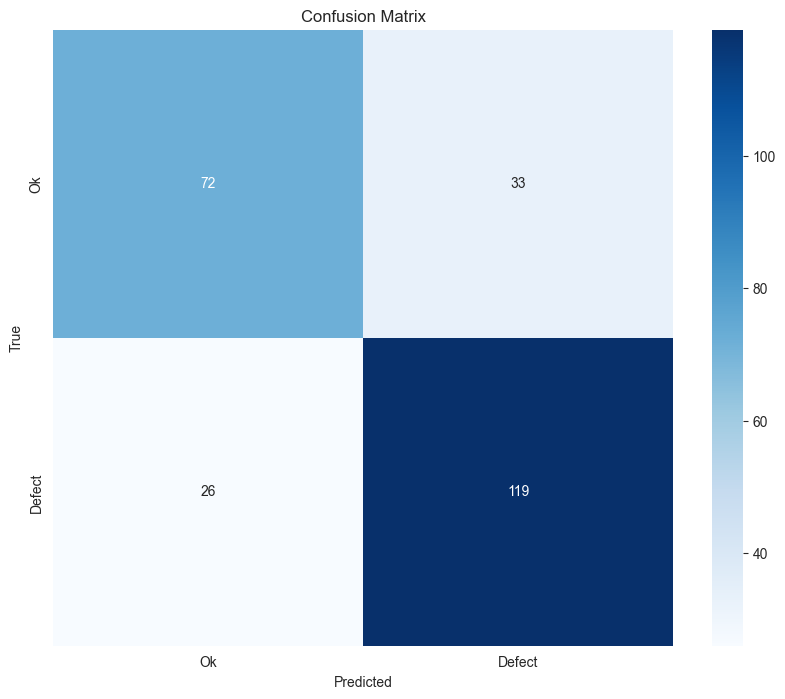

In [103]:
calculate_classification_evaluation_metrics(def_ok_classify_test_data_loader, ok_def_classify_model, def_ok_classify_classes.values())

### Free Memory And Garbage Collection

In [104]:
del def_ok_classify_inputs, def_ok_classify_targets, ok_def_classify_model, def_ok_classify_inputs_train, def_ok_classify_inputs_test, def_ok_classify_targets_train, def_ok_classify_targets_test, def_ok_classify_train_data_loader, def_ok_classify_test_data_loader
gc.collect()

4285

# Phase 2

### Noise Classification

In [105]:
noise_classify_inputs = np.array(noise_classify_dataframe["image_address"].values)
noise_classify_targets = np.array(noise_classify_dataframe["labels"].values)
image_shape = cv.imread(f"{base_image_path}{noise_classify_inputs[0]}", cv.IMREAD_GRAYSCALE).shape

In [106]:
noise_classify_model = ClassificationModel(1, image_shape[0], image_shape[1], len(noise_classify_classes), epochs=100, learning_rate=1e-4)
noise_classify_model.to(noise_classify_model.device)

Using cuda device


ClassificationModel(
  (conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4))
  (dropout_1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=128, out_features=3, bias=True)
  (softmax_1): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)

In [107]:
noise_classify_inputs_train, noise_classify_inputs_test, noise_classify_targets_train, noise_classify_targets_test = train_test_split(noise_classify_inputs, noise_classify_targets, test_size=0.2, shuffle=True)

In [108]:
noise_classify_train_dataset = CustomClassifyImageDataset(base_image_path, noise_classify_inputs_train, noise_classify_targets_train)
noise_classify_test_dataset = CustomClassifyImageDataset(base_image_path, noise_classify_inputs_test, noise_classify_targets_test)
noise_classify_train_data_loader, noise_classify_test_data_loader = DataLoader(noise_classify_train_dataset, batch_size=5), DataLoader(noise_classify_test_dataset, batch_size=5)

In [109]:
noise_classify_model.fit_loop(noise_classify_train_data_loader, noise_classify_test_data_loader)

Epoch number: 100

Model structure: ClassificationModel(
  (conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4))
  (dropout_1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=128, out_features=3, bias=True)
  (softmax_1): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)


Layer: conv_layer_1.weight | Size: torch.Size([16, 1, 3, 3]) | Values : tensor([[[[-0.1040,  0.1021, -0.3202],
          [ 0.1788, -0.2052,  0.2661],
          [-0.2345,  0.1302, -0.1287]]],


        [[[-0.0855,  0.2714,  0.2697],
          [-0.3192, -0.0493, -0.1222],
          [-0.3071, -0.0548, -0.2794]]]], device='cuda:0',
       grad_fn=<SliceBackward0>) 

Layer: conv_layer_1.bias | Size: torch.Size([16]) | Values : tensor([0.2639, 0.3136], devic

Accuracy: 0.7320
Precision: 0.8464
Recall: 0.7320
F1-Score: 0.6646


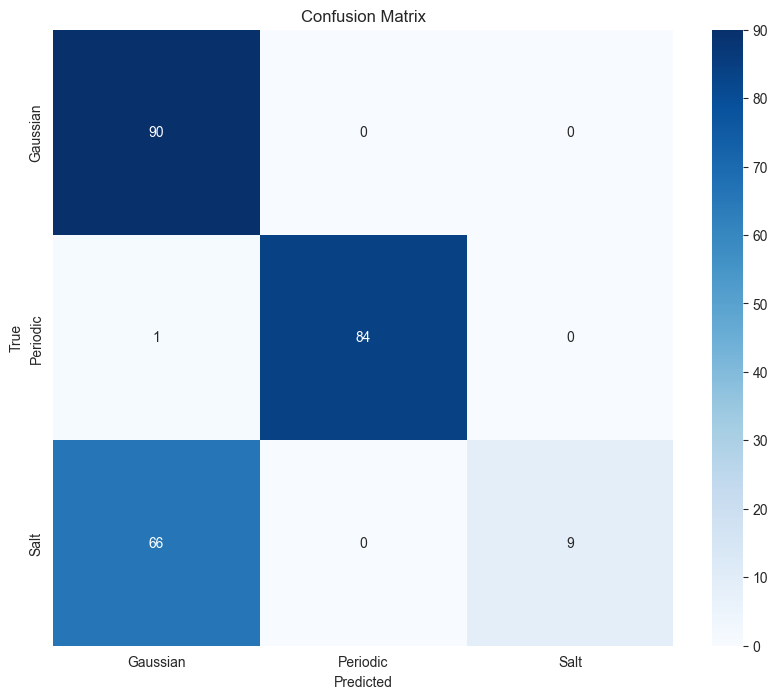

In [110]:
calculate_classification_evaluation_metrics(noise_classify_test_data_loader, noise_classify_model, noise_classify_classes.values())

In [111]:
del noise_classify_inputs, noise_classify_targets, noise_classify_model, noise_classify_inputs_train, noise_classify_inputs_test, noise_classify_targets_train, noise_classify_targets_test, noise_classify_train_data_loader, noise_classify_test_data_loader
gc.collect()

5133

### Denoising

In [23]:
denoise_inputs = np.array(denoise_dataframe["noise_image"].values)
denoise_targets = np.array(denoise_dataframe["noise_free_image"].values)

In [24]:
denoise_model = DenoisingModel(1, base_image_path, epochs=30, learning_rate=1e-4)
denoise_model.to(denoise_model.device)

Using cuda device


DenoisingModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
  (loss_fn): MSELoss()
)

In [25]:
denoise_inputs_train, denoise_inputs_test, denoise_targets_train, denoise_targets_test = train_test_split(denoise_inputs, denoise_targets, test_size=0.2, shuffle=True)

In [26]:
denoise_train_dataset = CustomDenoiseImageDataset(base_image_path, denoise_inputs_train, denoise_targets_train)
denoise_test_dataset = CustomDenoiseImageDataset(base_image_path, denoise_inputs_test, denoise_targets_test)
denoise_train_data_loader, denoise_test_data_loader = DataLoader(denoise_train_dataset, batch_size=5), DataLoader(denoise_test_dataset, batch_size=5)

In [116]:
denoise_model.fit_loop(denoise_train_data_loader, denoise_test_data_loader)

Epoch number: 30

Model structure: DenoisingModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
  (loss_fn): MSELoss()
)


Layer: encoder.0.weight | Size: torch.Size([64, 1, 3, 3]) | Values : tensor([[[[-0.2552,  0.0683, -0.0617],
          [-0.1893,  0.3277,  0.1731],
          [-0.2827, -0.1306, -0.2388]]],


        [[[-0.2355,  0.11

In [117]:
calculate_denoising_metrics(denoise_model, denoise_test_data_loader)
lpips_avg = calculate_lpips(denoise_model, denoise_test_data_loader)

Average PSNR: 26.0699
Average SSIM: 0.7190
Average MSE: 0.0054
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


C:\Users\mahdi\Desktop\University\Digital_Image_Processing\Final_Project\DIP_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mahdi\Desktop\University\Digital_Image_Processing\Final_Project\DIP_Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\mahdi\Desktop\University\Digital_Image_Processing\Final_Project\DIP_Project\.venv\Lib\site-packages\lpips\weights\v0.1\alex.pth
Average LPIPS: 0.2754


In [27]:
del denoise_inputs_train, denoise_inputs_test, denoise_targets_train, denoise_targets_test, denoise_train_dataset, denoise_test_dataset, denoise_train_data_loader, denoise_test_data_loader, lpips_avg
gc.collect()

4390

### Saving Denoised Images

In [122]:
if os.path.exists(base_denoised_images_path):
    # If it exists, delete the directory and its contents
    shutil.rmtree(base_denoised_images_path)
    # Create the directory
os.makedirs(base_denoised_images_path)
denoise_images_dataset = CustomDenoiseImageDatasetPredOnly(base_image_path, denoise_inputs)
denoise_images_dataloader = DataLoader(denoise_images_dataset, batch_size=5)
with torch.no_grad():
    for batch, X in enumerate(denoise_images_dataloader):
        X = X.to(denoise_model.device)
        denoised_images_batch = denoise_model(X)
        for batch_member, denoised_image in enumerate(denoised_images_batch):
            img_denoised = np.array(denoised_image.cpu().numpy()[0]) *255
            cv.imwrite(f"{base_denoised_images_path}{denoise_inputs[(batch*5)+batch_member].split('/')[-1]}", img_denoised)

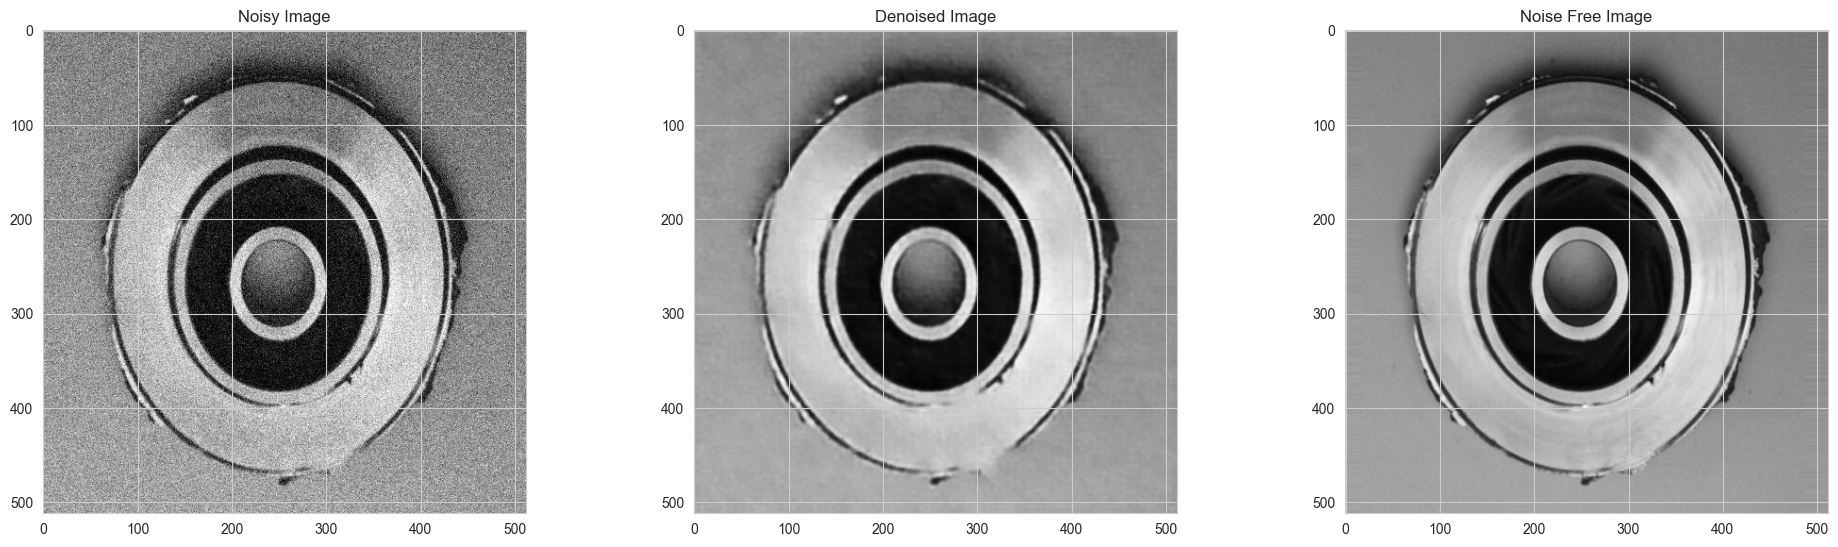

In [133]:
denoise_example_img_noisy = cv.imread(f"{base_image_path}{denoise_inputs[0]}", cv.IMREAD_GRAYSCALE)
denoise_example_img_denoised = cv.imread(f"{base_denoised_images_path}{denoise_inputs[0].split('/')[-1]}", cv.IMREAD_GRAYSCALE)
denoise_example_img_noise_free = cv.imread(f"{base_image_path}{denoise_targets[0]}", cv.IMREAD_GRAYSCALE)
denoise_results_fig , denoise_results_axes = plt.subplots(1, 3)
denoise_results_fig.tight_layout()
denoise_results_fig.set_size_inches(20,12)
denoise_results_axes.flatten()
denoise_results_axes[0].imshow(denoise_example_img_noisy, cmap="gray")
denoise_results_axes[0].set_title("Noisy Image")
denoise_results_axes[1].imshow(denoise_example_img_denoised, cmap="gray")
denoise_results_axes[1].set_title("Denoised Image")
denoise_results_axes[2].imshow(denoise_example_img_noise_free, cmap="gray")
denoise_results_axes[2].set_title("Noise Free Image")
plt.show()


In [ ]:
del denoise_inputs, denoise_targets, denoise_model, denoise_images_dataloader, denoise_images_dataset, denoise_example_img_noisy, denoise_example_img_denoised, denoise_example_img_noise_free, denoise_results_fig, denoise_results_axes
gc.collect()

# Phase 3

### Ok / Defect Classification With Denoised Images

In [17]:
def_ok_denoised_classify_inputs = np.array(def_ok_classify_dataframe["image_address"].apply(lambda x: x.split('/')[-1]))
def_ok_denoised_classify_targets = np.array(def_ok_classify_dataframe["labels"].values)
image_shape = cv.imread(f"{base_denoised_images_path}{def_ok_denoised_classify_inputs[0]}", cv.IMREAD_GRAYSCALE).shape

In [18]:
ok_def_denoised_classify_model = ClassificationModel(1, image_shape[0], image_shape[1], len(def_ok_classify_classes), epochs=100, learning_rate=1e-4)
ok_def_denoised_classify_model.to(ok_def_denoised_classify_model.device)

Using cuda device


ClassificationModel(
  (conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4))
  (dropout_1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=128, out_features=2, bias=True)
  (softmax_1): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)

In [19]:
def_ok_denoised_classify_inputs_train, def_ok_denoised_classify_inputs_test, def_ok_denoised_classify_targets_train, def_ok_denoised_classify_targets_test = train_test_split(def_ok_denoised_classify_inputs, def_ok_denoised_classify_targets, test_size=0.2, shuffle=True)

In [20]:
def_ok_denoised_classify_train_dataset = CustomClassifyImageDataset(base_denoised_images_path, def_ok_denoised_classify_inputs_train, def_ok_denoised_classify_targets_train)
def_ok_denoised_classify_test_dataset = CustomClassifyImageDataset(base_denoised_images_path, def_ok_denoised_classify_inputs_test, def_ok_denoised_classify_targets_test)
def_ok_denoised_classify_train_data_loader, def_ok_denoised_classify_test_data_loader = DataLoader(def_ok_denoised_classify_train_dataset, batch_size=5), DataLoader(def_ok_denoised_classify_test_dataset, batch_size=5)

In [21]:
ok_def_denoised_classify_model.fit_loop(def_ok_denoised_classify_train_data_loader, def_ok_denoised_classify_test_data_loader)

Epoch number: 100

Model structure: ClassificationModel(
  (conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (conv_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4))
  (dropout_1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=32768, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=128, out_features=2, bias=True)
  (softmax_1): Softmax(dim=1)
  (loss_fn): CrossEntropyLoss()
)


Layer: conv_layer_1.weight | Size: torch.Size([16, 1, 3, 3]) | Values : tensor([[[[ 0.3254, -0.1681,  0.0941],
          [ 0.0634, -0.2966,  0.0053],
          [ 0.0989, -0.2746,  0.3268]]],


        [[[ 0.0991, -0.1413, -0.1622],
          [-0.3265,  0.0857,  0.0893],
          [-0.0253, -0.0514,  0.0173]]]], device='cuda:0',
       grad_fn=<SliceBackward0>) 

Layer: conv_layer_1.bias | Size: torch.Size([16]) | Values : tensor([-0.0754,  0.1350], dev

Accuracy: 0.8040
Precision: 0.8028
Recall: 0.8040
F1-Score: 0.8031


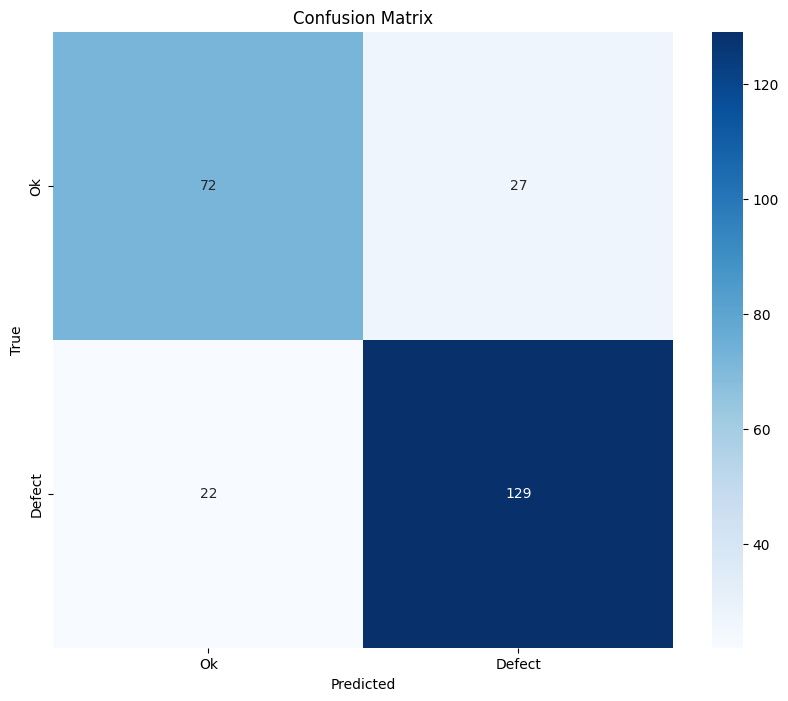

In [22]:
calculate_classification_evaluation_metrics(def_ok_denoised_classify_test_data_loader, ok_def_denoised_classify_model, def_ok_classify_classes.values())